# Titanic Data Analysis

Welcome to my analysis of the Titanic Data Set. 

## Introduction
A brief introduction from [Wikipedia](https://en.wikipedia.org/wiki/RMS_Titanic):
>[The] RMS Titanic (/taɪˈtænɪk/) was a British passenger liner that sank in the North Atlantic Ocean in the early morning of 15 April 1912, after colliding with an iceberg during her maiden voyage from Southampton to New York City. Of the 2,224 passengers and crew aboard, more than 1,500 died, making it one of the deadliest commercial peacetime maritime disasters in modern history. The largest ship afloat at the time it entered service, the RMS Titanic was the second of three Olympic class ocean liners operated by the White Star Line, and was built by the Harland and Wolff shipyard in Belfast. Thomas Andrews, her architect, died in the disaster.

## Main Question
For this analysis I will endeavour to answer one simple question: is there a statistically significant difference between male and female survival rates? More specificially, if females had a statistically significant advantage over their male counterparts. The results will be held to $\alpha$ = 0.01, and tested as a 1-Tailed Z-Score. 

This question, posed formally:
$$H_0: \mu_m - \mu_f = 0$$
$$H_1: \mu_m - \mu_f < 0$$
Where $\mu$ is the survival rate for each respective gender. 


## Table Descriptions

### VARIABLE DESCRIPTIONS:
- survival        Survival (0 = No; 1 = Yes)
- pclass          Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
- name            Name
- sex             Sex
- age             Age
- sibsp           Number of Siblings/Spouses Aboard
- parch           Number of Parents/Children Aboard
- ticket          Ticket Number
- fare            Passenger Fare
- cabin           Cabin
- embarked        Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

### SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored.  The following are the definitions used
for sibsp and parch.

- Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
- Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
- Parent:   Mother or Father of Passenger Aboard Titanic
- Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins,
nephews/nieces, aunts/uncles, and in-laws.  Some children travelled
only with a nanny, therefore parch=0 for them.  As well, some
travelled with very close friends or neighbors in a village, however,
the definitions do not support such relations.

## Importing modules, data, and quick data checking

In [1]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

#load data
df = pd.read_csv("titanic-data.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Checking Data Types
Doing this to verify variables are reading in as intended.

In [2]:
df.columns.to_series().groupby(df.dtypes).groups

{dtype('int64'): Index(['PassengerId', 'Survived', 'Pclass', 'SibSp', 'Parch'], dtype='object'),
 dtype('float64'): Index(['Age', 'Fare'], dtype='object'),
 dtype('O'): Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')}

## Defining Functions and Data Wrangling
Some initial functions to begin working with the data. Also directly beneath my functions are any statements to modify the original data set necessary to the rest of the analysis. 

*please note my naming convention for a function I plan on using in a .apply is appFunction - short for applyFunction*

In [3]:
def appGender(row):
    """DEPRECATED thanks to helpful suggestion from first reviewer. Left for clarity of process!
    Switched to a .map function (which is way cleaner!)
    
    Returns 0 for male, 1 for Female
    
    Used in df.apply to change 'male' / 'female' to 0 / 1 respectively.
    """
    if row['Sex'] == 'male': return 0
    else: return 1

In [4]:
df['gender'] = df['Sex'].map({'male':0, 'female':1})
df['strSurvived'] = df['Survived'].map({0:'Died', 1:'Survived'})
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,gender,strSurvived
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Died
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Survived
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Survived
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Survived
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Died


## Wrangling and Exploring
I'm going to start this process by simply examining the full dataframe, checking for missing values, getting a basic lay of the data. Then I'll move down into descriptions of gender seperated tables. 

### Population Statistics
Now that we've gotten a good clean table to work from, and added additional columns for analytical purposes, we can begin to look at how the entire population did, then subsection it down and compare. 

In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,gender
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.352413
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.477990
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


#### Holy insights! 
Let's break down some key numbers:
- There are 891 passengers in the set. Of those, 177 are missing ages. To address the missing values I will substitute the mean age for any NaN ages, after the next section. It appears that Age is the only field with missing values as the rest are consistent at 891. 
- It appears that there are no other missing fields with missing values from our initial table description. If any more are uncovered they will be addressed and dealt with midstream. 
- The overall survival rate was ~38% ($\mu = 38\%$) 
- Of the passengers, ~35% were female. 

To examine our hypothesis we we look to see if females have a abnormally larger survival rate than males:

In [6]:
# a look at females general population statistics
df[df['gender'] == 1].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,gender
count,314.000000,314.000000,314.000000,261.000000,314.000000,314.000000,314.000000,314.0
mean,431.028662,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818,1.0
std,256.846324,0.438211,0.857290,14.110146,1.156520,1.022846,57.997698,0.0
min,2.000000,0.000000,1.000000,0.750000,0.000000,0.000000,6.750000,1.0
25%,231.750000,0.000000,1.000000,18.000000,0.000000,0.000000,12.071875,1.0
50%,414.500000,1.000000,2.000000,27.000000,0.000000,0.000000,23.000000,1.0
75%,641.250000,1.000000,3.000000,37.000000,1.000000,1.000000,55.000000,1.0
max,889.000000,1.000000,3.000000,63.000000,8.000000,6.000000,512.329200,1.0


In [7]:
# a look at male general population statistics
df[df['gender'] == 0].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,gender
count,577.000000,577.000000,577.000000,453.000000,577.000000,577.000000,577.000000,577.0
mean,454.147314,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893,0.0
std,257.486139,0.391775,0.813580,14.678201,1.061811,0.612294,43.138263,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.0
25%,222.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.0
50%,464.000000,0.000000,3.000000,29.000000,0.000000,0.000000,10.500000,0.0
75%,680.000000,0.000000,3.000000,39.000000,0.000000,0.000000,26.550000,0.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,5.000000,512.329200,0.0


#### Digging Deeper: A first look at Female v.s. Male populations
From these two tables we can get some real insight to run on, we now know:
- There were 314 females, and 577 males.
- All missing ages were from the female population. 
- Survival rate = Males: 18% | Females: 74%
- Average Age = Males: 30 | Females: 27

#### Checking correlations at a higher level
A quick look at Perasons product-moment correlation coefficient to corroborate our initial findings. 

In [8]:
pearson = np.corrcoef(x=df['gender'], y=df['Survived'])
print(pearson.mean())

0.771675690329


Yes, we can see that gender and survived are very positively correlated (keep in mind 1 is female and 1 is survived). 

Now let's fix the missing age values:

In [9]:
# fills df['Age'] missing values with the mean from the same column
df['Age'].fillna(df['Age'].mean())
print("Ages fixed!")

Ages fixed!


### Taking it even further
Now that the data is whole, it's time to look at our data via some neat graphs. First we'll establish formatting, then examine various aspects of the data. 

In [10]:
#first we must format :)
sns.set(font_scale=1.6, 
        font='calibri', 
        rc={ 
            'grid.color': '.8',
        },
)
# naming convention for colors = {Gender (f/m)}{Class (1/2/3)}
f1 = '#c39738'
f2 = '#9D44B5'
f3 = '#B5446E'
m1 = '#525252'
m2 = '#7A5C61'
m3 = '#6874E8'
# split the df up just for plotting [NO MANIPULATION DONE WITH THESE SETS]
# sole purpose is so I don't have to waste space with gender conditions for every chart..
women = df[(df.gender == 1)]
men = df[(df.gender == 0)]

### Charts!
We're formatted, we're clean, we're ready to chart! 

I've decided to start with a pairplot, to examine basic relations between multiple factors in the df.

In [11]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,gender,strSurvived
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Died
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Survived
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Survived
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Survived
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Died


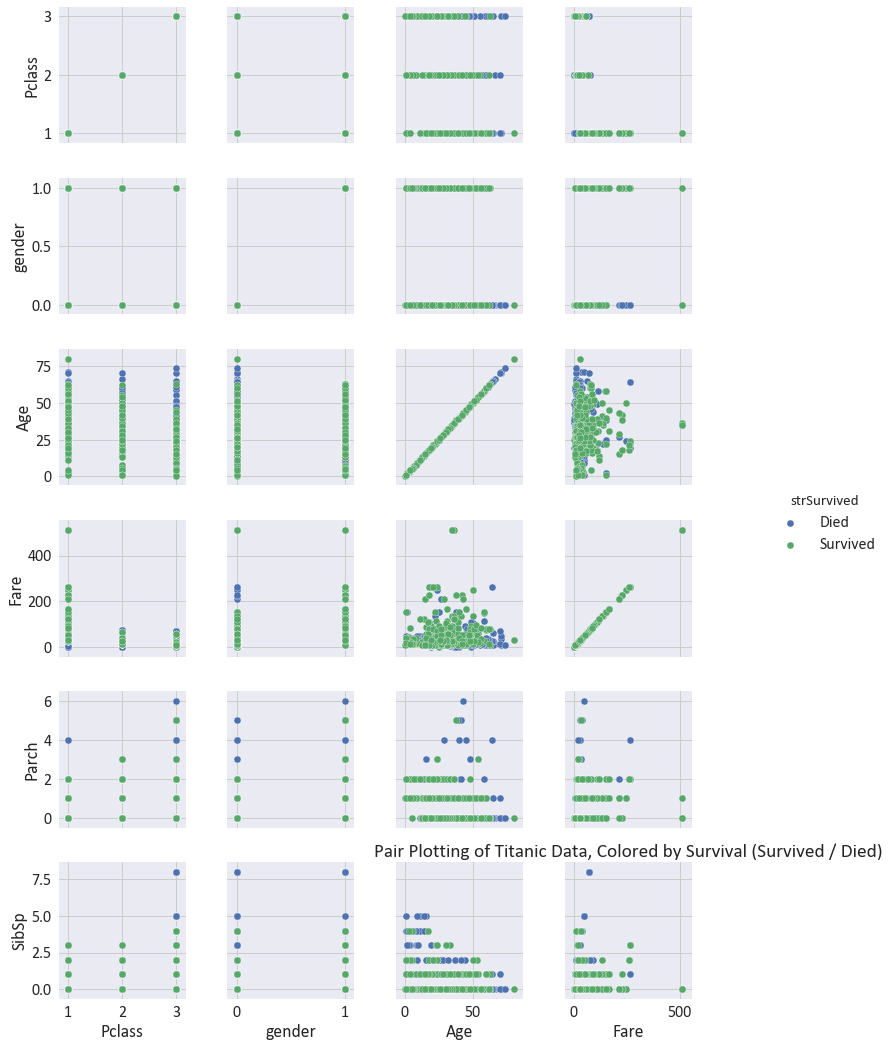

In [12]:
plt.figure()
sns.pairplot(data=df, 
             hue='strSurvived', 
             dropna=True, 
             x_vars=('Pclass', 'gender', 'Age', 'Fare'),
             y_vars=('Pclass', 'gender', 'Age', 'Fare', 'Parch', 'SibSp')
)
plt.title("Pair Plotting of Titanic Data, Colored by Survival (Survived / Died)")
plt.show()

#### Results of pairplot
Few very interesting notes from the chart above are:
- Seems as though younger people had better odds than old. 
- Higher fair seems to correlate slightly with survival rate. 
- Younger people tended to survive regardless of fare. 
- Older males may have given up seats for younger, or higher-class individuals. 

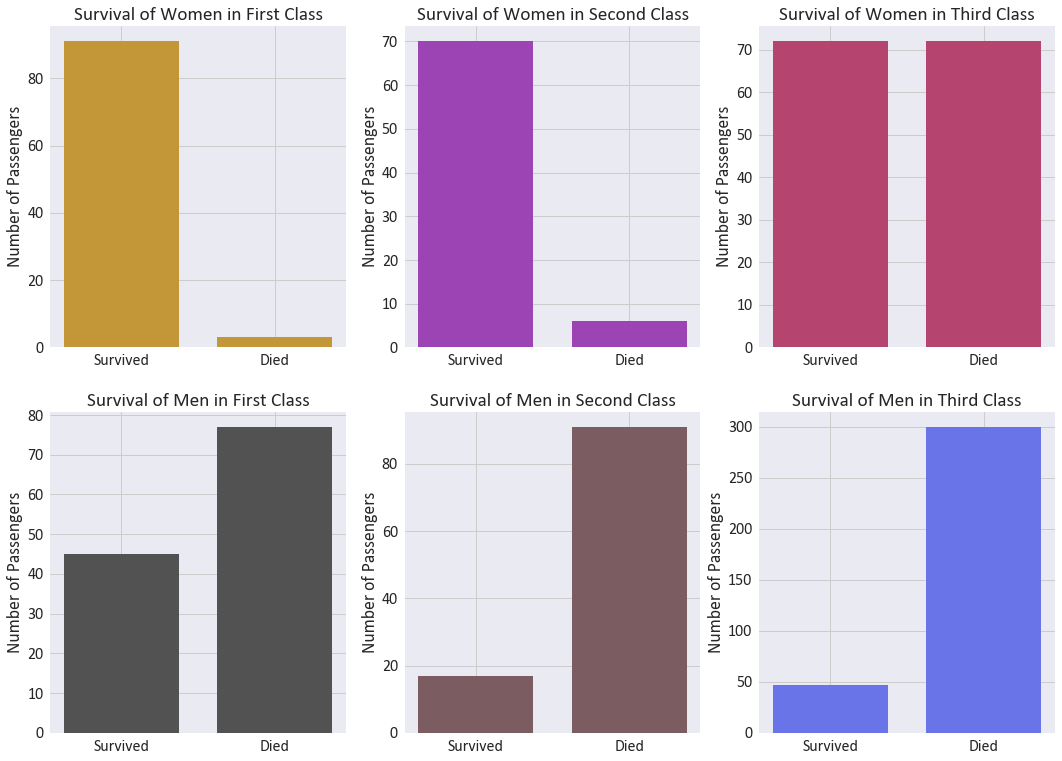

In [13]:
# establlish our subplots, going to go with a 2 by 3 grid to examine relationships between gender, class, and survival. 
fig, axes = plt.subplots(2, 3, figsize=(18, 13))
# bins since they're all the same size / shape
N = 2
ind = np.arange(N)
width = .75

# Starting with women in first class -> second -> third; then men first -> second -> third
ax1 = plt.subplot2grid((2, 3), (0,0))
data = (
    women.Survived[(women.Survived == 1) & (women.Pclass == 1)].count(),
    women.Survived[(women.Survived == 0) & (women.Pclass == 1)].count(),
)
plt.bar(ind, data, width, color=f1)
plt.xticks(ind, ('Survived', 'Died'))
plt.ylabel("Number of Passengers")
plt.title("Survival of Women in First Class")

ax2 = plt.subplot2grid((2, 3), (0, 1))
data = (
    women.Survived[(women.Survived == 1) & (women.Pclass == 2)].count(),
    women.Survived[(women.Survived == 0) & (women.Pclass == 2)].count(),
)
plt.bar(ind, data, width, color=f2)
plt.xticks(ind, ('Survived', 'Died'))
plt.ylabel("Number of Passengers")
plt.title("Survival of Women in Second Class")

ax3 = plt.subplot2grid((2, 3), (0, 2))
data = (
    women.Survived[(women.Survived == 1) & (women.Pclass == 3)].count(),
    women.Survived[(women.Survived == 0) & (women.Pclass == 3)].count(),
)
plt.bar(ind, data, width, color=f3)
plt.xticks(ind, ('Survived', 'Died'))
plt.ylabel("Number of Passengers")
plt.title("Survival of Women in Third Class")

ax4 = plt.subplot2grid((2, 3), (1, 0))
data = (
    men.Survived[(men.Survived == 1) & (men.Pclass == 1)].count(),
    men.Survived[(men.Survived == 0) & (men.Pclass == 1)].count(),
)
plt.bar(ind, data, width, color=m1)
plt.xticks(ind, ('Survived', 'Died'))
plt.ylabel("Number of Passengers")
plt.title("Survival of Men in First Class")

ax5 = plt.subplot2grid((2, 3), (1, 1))
data = (
    men.Survived[(men.Survived == 1) & (men.Pclass == 2)].count(),
    men.Survived[(men.Survived == 0) & (men.Pclass == 2)].count(),
)
plt.bar(ind, data, width, color=m2)
plt.xticks(ind, ('Survived', 'Died'))
plt.ylabel("Number of Passengers")
plt.title("Survival of Men in Second Class")

ax6 = plt.subplot2grid((2, 3), (1, 2))
data = (
    men.Survived[(men.Survived == 1) & (men.Pclass == 3)].count(),
    men.Survived[(men.Survived == 0) & (men.Pclass == 3)].count(),
)
plt.bar(ind, data, width, color=m3)
plt.xticks(ind, ('Survived', 'Died'))
plt.ylabel("Number of Passengers")
plt.title("Survival of Men in Third Class")

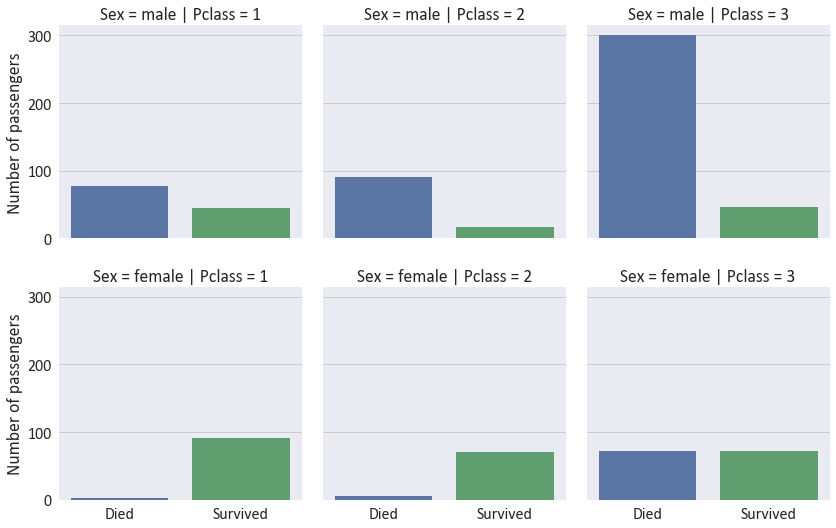

In [25]:
# code block from reviewer, placed in here for future reference. 
# first line is already achieved in survivedStr
# df['Survived'].replace({0:'Died', 1:'Survived'}, inplace=True)
ax = sns.factorplot(y='PassengerId', x='strSurvived', estimator=len, data=df, row='Sex', col='Pclass', kind='bar')
ax.set_xlabels('')
ax.set_ylabels('Number of passengers')

#### Insights from Survival rates split by gender and class
From the above charts we can see a female passenger is more likely to have been saved in every class comparetively to their male counterparts. The subclass presented here with the highest odds of surviving (by no surprise) are the females of first class. The lowest odds can be found between males of second and third class, who did not fair so well. 

This may be due to several causes, it could have been that women were prioritized for lifeboat positions, perhaps along with children, which of course would align to longstanding cultural ideals. To verify this suspiscion (and it's connection to my main premise) we will continue to explore the data visually, then attempt to draw concolusions statistically to affirm our hunches. 

Firstly I'd like to examine how the female population presents as a stacked graph, thus showing the population as a whole and the comparisons in survival between them. 

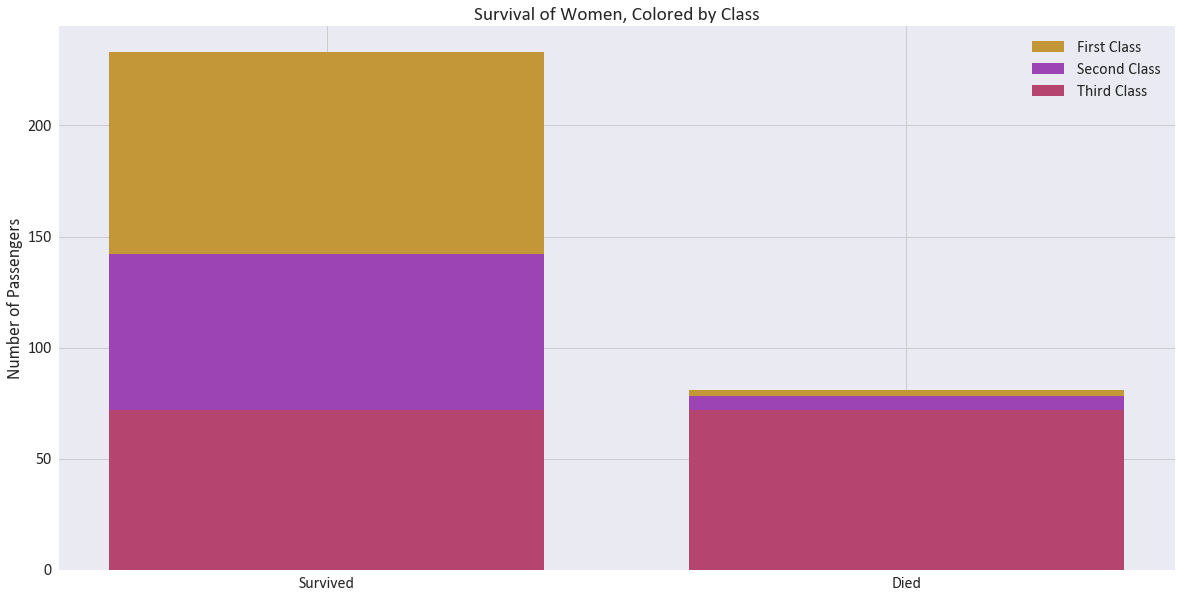

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
# now to split the data for an intresting stacking experiment
wclass1 = (
    women.Survived[(women.Pclass == 1) & (women.Survived == 1)].count(),
    women.Survived[(women.Pclass == 1) & (women.Survived == 0)].count(),
)
wclass2 = (
    women.Survived[(women.Pclass == 2) & (women.Survived == 1)].count(),
    women.Survived[(women.Pclass == 2) & (women.Survived == 0)].count(),
)
wclass3 = (
    women.Survived[(women.Pclass == 3) & (women.Survived == 1)].count(),
    women.Survived[(women.Pclass == 3) & (women.Survived == 0)].count(), 
)
# bin settings
N = 2
ind = np.arange(N)
width = .75
# stack, stack, stack em up
c3 = plt.bar(ind, wclass3, width, color=f3)
c2 = plt.bar(ind, wclass2, width, color=f2, bottom=wclass3)
c1 = plt.bar(ind, wclass1, width, color=f1, bottom=(np.array(wclass3)+np.array(wclass2)))
# add the fancy-shmancy labels so other 'hoomans' can read
plt.xticks(ind, ('Survived', 'Died'))
plt.ylabel("Number of Passengers")
plt.title("Survival of Women, Colored by Class")
plt.legend((c1[0], c2[0], c3[0]), ('First Class', 'Second Class', 'Third Class'))

#### That's a very little bit of gold you have there. 
I've picked gold for females of first class for this reason, it seems really as though they were treated like gold. We can see here that in the population of women first class females make an extremely small fraction of the deceased. This aligns pretty closely to the trends noted above. 

Now it's time to look at the mens ratios in the same manner. 

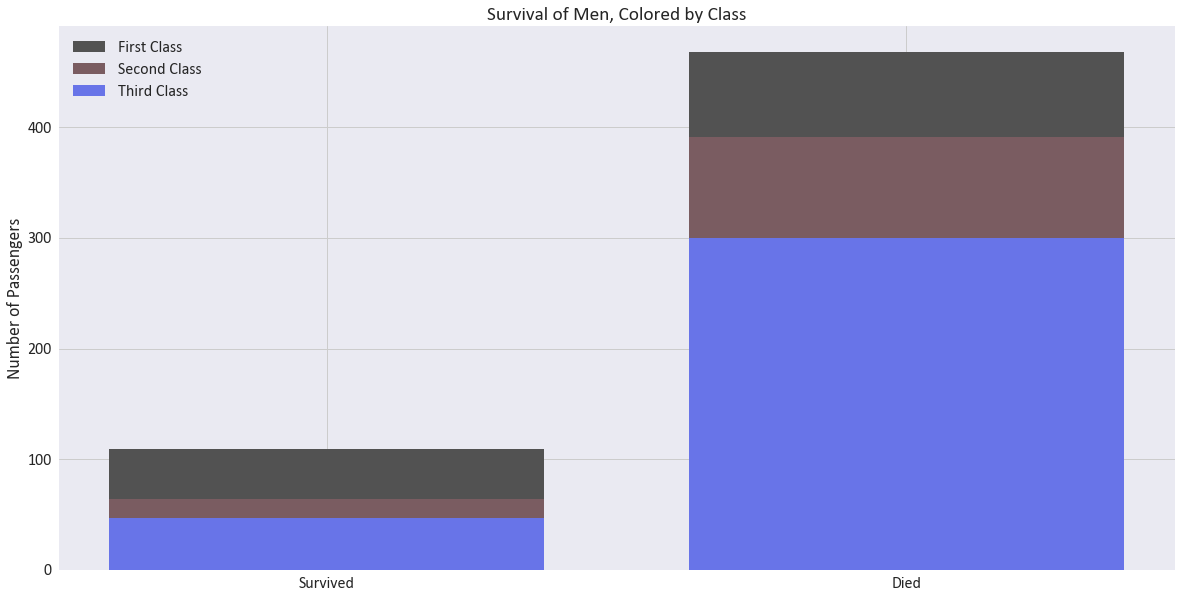

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
# now to split the data for an intresting stacking experiment    
mclass1 = (
    men.Survived[(men.Pclass == 1) & (men.Survived == 1)].count(),
    men.Survived[(men.Pclass == 1) & (men.Survived == 0)].count(),
)
mclass2 = (
    men.Survived[(men.Pclass == 2) & (men.Survived == 1)].count(),
    men.Survived[(men.Pclass == 2) & (men.Survived == 0)].count(),
)
mclass3 = (
    men.Survived[(men.Pclass == 3) & (men.Survived == 1)].count(),
    men.Survived[(men.Pclass == 3) & (men.Survived == 0)].count(), 
)
# bin settings
N = 2
ind = np.arange(N)
width = .75
# stack, stack, stack em up
c3 = plt.bar(ind, mclass3, width, color=m3)
c2 = plt.bar(ind, mclass2, width, color=m2, bottom=mclass3)
c1 = plt.bar(ind, mclass1, width, color=m1, bottom=(np.array(mclass3)+np.array(mclass2)))
# add the fancy-shmancy labels so other 'hoomans' can read
plt.xticks(ind, ('Survived', 'Died'))
plt.ylabel("Number of Passengers")
plt.title("Survival of Men, Colored by Class")
plt.legend((c1[0], c2[0], c3[0]), ('First Class', 'Second Class', 'Third Class'))

#### Well that's bleak
It seems that males, regardless of class were doomed...
Additionally we can also see here the only class with even a nearly even rate is first class.

But what happens if we stack them all up?

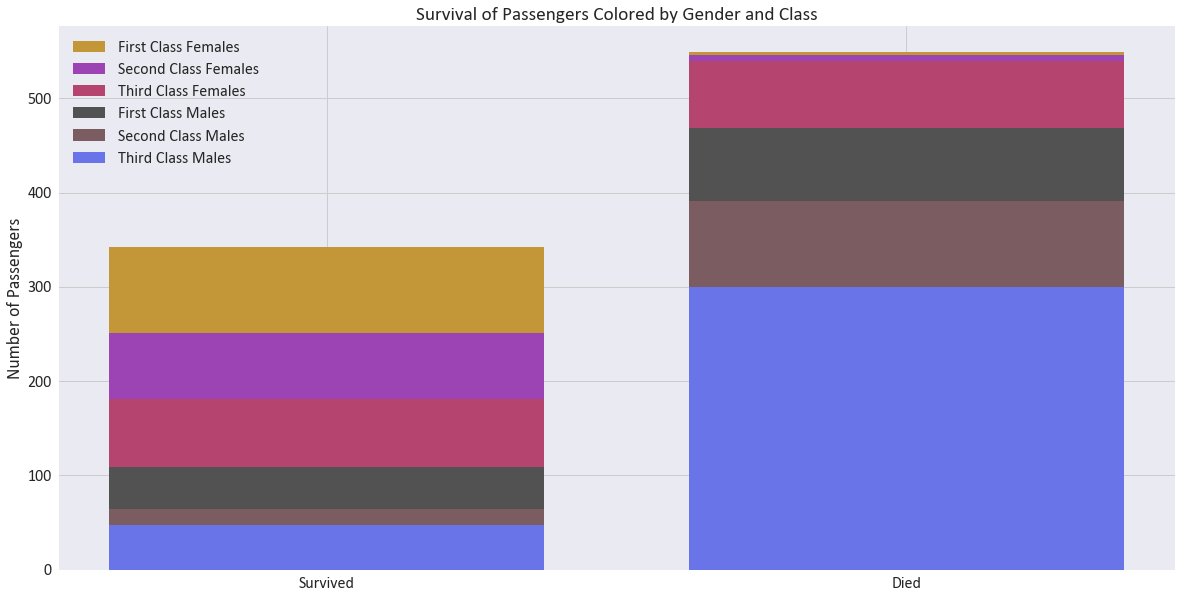

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))
# bin settings
N = 2
ind = np.arange(N)
width = .75
# stack, stack, stack em up
m3 = plt.bar(ind, mclass3, width, color=m3)
y = np.array(mclass3)
m2 = plt.bar(ind, mclass2, width, color=m2, bottom=y)
y += np.array(mclass2)
m1 = plt.bar(ind, mclass1, width, color=m1, bottom=y)
y += np.array(mclass1)
f3 = plt.bar(ind, wclass3, width, color=f3, bottom=y)
y += np.array(wclass3)
f2 = plt.bar(ind, wclass2, width, color=f2, bottom=y)
y += np.array(wclass2)
f1 = plt.bar(ind, wclass1, width, color=f1, bottom=y)
# add the fancy-shmancy labels so other 'hoomans' can read
plt.xticks(ind, ('Survived', 'Died'))
plt.ylabel("Number of Passengers")
plt.title("Survival of Passengers Colored by Gender and Class")
plt.legend(
    (f1[0], f2[0], f3[0], m1[0], m2[0], m3[0]), 
    (
        'First Class Females', 'Second Class Females', 'Third Class Females',
        'First Class Males', 'Second Class Males', 'Third Class Males'        
    )
)
plt.show()

#### Interesting!
To start with something unexpected, I'd like to direct your attention to the brown block (second class males), what's interesting is that they are actually the smallest group of survivors! We can still clearly see women are the main survivors, no other group even compares to women of first class. 

This could be a result of numerous factors, but I think the simplest solution - Chivalry - can take much of the credit for this one.

Time to look at the actual survival rates between the classes and genders. 

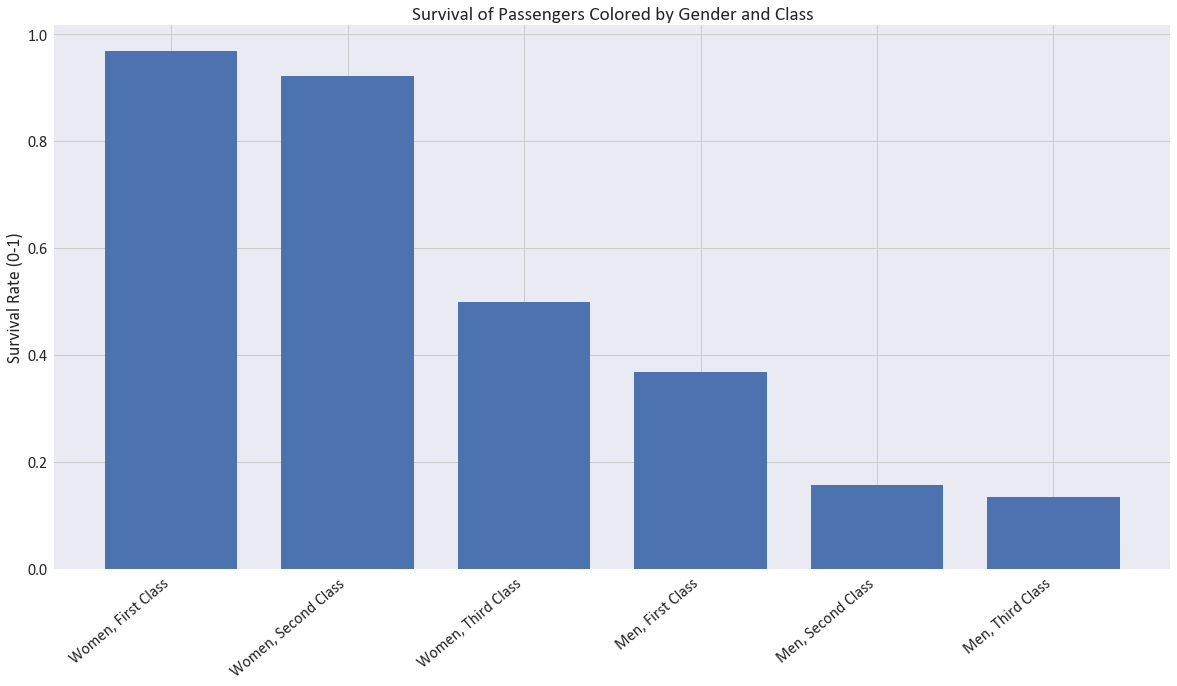

In [19]:
# creating a plot of chances of survival by class and gender!
data = (
    df.Survived[(df.gender == 1) & (df.Pclass == 1)].mean(),
    df.Survived[(df.gender == 1) & (df.Pclass == 2)].mean(),
    df.Survived[(df.gender == 1) & (df.Pclass == 3)].mean(),
    df.Survived[(df.gender == 0) & (df.Pclass == 1)].mean(),
    df.Survived[(df.gender == 0) & (df.Pclass == 2)].mean(),
    df.Survived[(df.gender == 0) & (df.Pclass == 3)].mean(),
)
labels = (
    "",
    "Women, First Class",
    "Women, Second Class",
    "Women, Third Class",
    "Men, First Class",
    "Men, Second Class",
    "Men, Third Class"
)
fig, ax = plt.subplots(figsize=(20, 10))
# bin settings
N = 6
ind = np.arange(N)
width = .75
# stack, stack, stack em up
plt.bar(ind, data, width)
# add the fancy-shmancy labels so other 'hoomans' can read
plt.ylabel("Survival Rate (0-1)")
plt.title("Survival of Passengers as a Proportion")
ax.set_xticklabels(labels, rotation=40, ha='right')
plt.show()

#### Proportionally Safe
This paints a bleak picture for myself, a male, most likely second-class traveler, but _C'est la vie_.

## Statistical Analysis of Findings
To continue onto the numbers now; based on preliminary findings I can conclude that the female population as a whole would *not* be statistically strong enough to reject the null. Therefore I shall continue this analysis looking at the most fortunate group, females of first class; in an effort to find a single group with a statistically significant chance of survival. 

In [20]:
fem_mean = df.Survived[(df.gender == 1) & (df.Pclass == 1)].mean()
print(fem_mean)

0.9680851063829787


Approximately 96% of females in first class survied the incident. 

Compared to males in third class?

In [21]:
male_mean = df.Survived[(df.gender == 0) & (df.Pclass == 3)].mean()
print(male_mean)

0.13544668587896252


Well darn, ~13% are not good odds by any standard. 

Let's take a look at the Z-Scores of our various subgroups of the population. 

In [22]:
fem_z = (fem_mean - df.Survived.mean()) / df.Survived.std(ddof=0)
print(fem_z)

1.2013644144488933


Out of the whole population, there is a 15% chance of randomly selecting a group with the same mean as taken from the female passengers. While this margin of error will not allow me to reject the null. I'd like to compare the male group to this female subset - 

In [23]:
fem_z_toMale = (fem_mean - df.Survived[(df.gender == 0)].mean()) / df.Survived[(df.gender == 0)].std(ddof=0)
print(fem_z_toMale)

1.9905621426418676


So close. A 1.99 Z-Score, rejection of the null does not make though. Still, it is evident females did have quite different odds than males on this foregone cruiseship of yore. 

## Conclusion of main premise
From this we can conclude the condition of being female is significant, yet not significant to $\alpha = 0.01$
We are left with a 2% chance of random selection giving us this bias. I personally find this to still be significant as it passes at $\alpha = 0.05$. Unfortunately I did not set out to prove it at 5%. :(

## Limitations
This data set is fairly small compared to the actual number of passengers traveling on the ship. One can infer that the additional members may have allowed a statistical certainty here, but it would only be an inference, not certain by any means. 

I must also note the survivor bias inherent in this data set. Since researchers were only able to survey survivors of the incident we may be lacking in information from those who perished in the incident. 

### Resources Consulted
[Jupyter Notebook from Kaggle on Titanic Analysis](http://nbviewer.jupyter.org/github/agconti/kaggle-titanic/blob/master/Titanic.ipynb)

[Jupyter Notebook on Matplotlib](http://nbviewer.jupyter.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-4-Matplotlib.ipynb)

[PyPlot Docs](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.bar)

[Pandas Docs](http://pandas.pydata.org/pandas-docs/stable/dsintro.html)